In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 8})

# 活化函數大清點 (tensorflow)

支援python 版本: 3.5以上
支援tensorflow: 2.2以上

In [2]:
import gc
import glob
import os
import time
import cv2
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.layers.tensorflow_activations import __all__

trident 0.7.1


Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.
1 Physical GPUs, 1 Logical GPUs


Opencv version:4.1.2.
Pillow version:7.1.2.


Tensorflow version:2.4.0.
use device:/gpu:0.
executing_eagerly
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


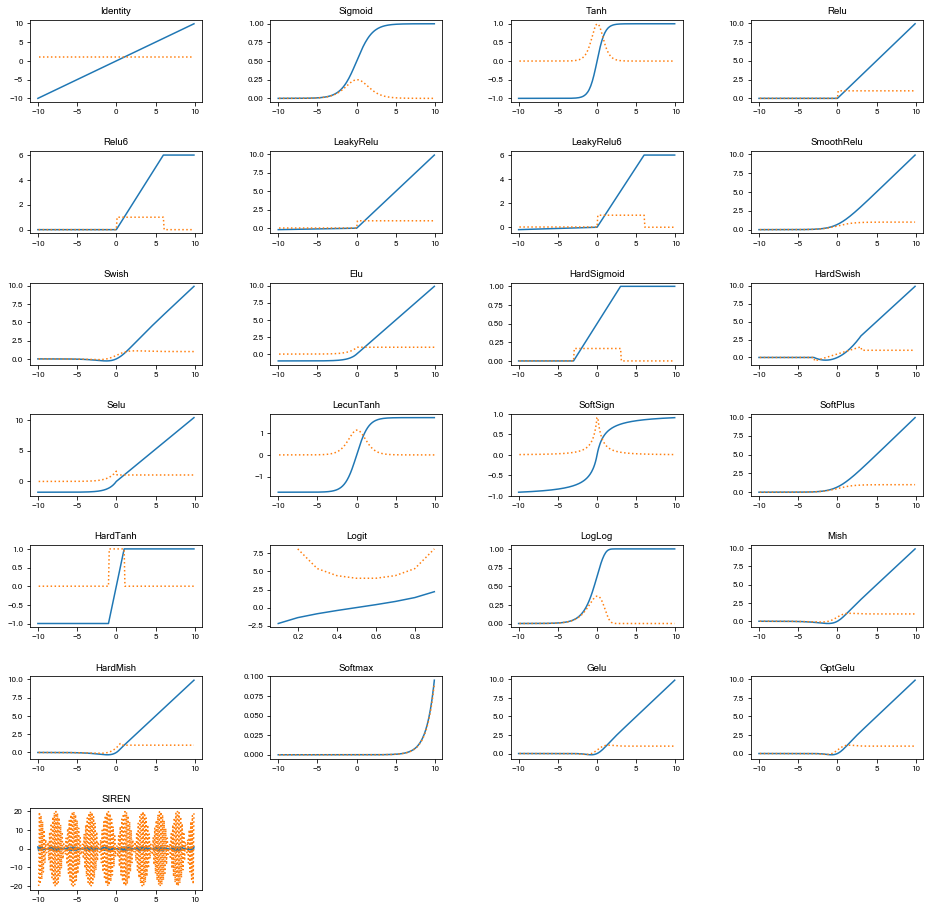

In [3]:
fig = plt.figure(figsize=(16, 16))
plt.ion()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
n = 1
items = __all__[:-1]  # 取得活化函數名稱清單

for k in items:
    if k not in ('PRelu','CRelu'):
        try:
            act_fn = get_activation(k)
            x = np.arange(-10, 10, 0.1).astype(np.float32) # 產生從-10到10之間，每隔0.1一筆的向量(x)
            tensor_x = expand_dims(to_tensor(x),0)  # 向量轉tensor
            y = to_numpy(act_fn(tensor_x))[0]  # 計算向量經過活化函數的結果(y)
            ax1 = fig.add_subplot(7, 4, n)  # 宣告6*4個子圖
            ax1.plot(x, y)  # 將x,y繪製圖表
            ax1.plot(x[1:], np.diff(y) / (np.diff(x) + 1e-8), ls=':')  # np.diff在計算隔一筆的差異。將y的微小變化除以x的微小變化就是梯度
            ax1.set_title(k)

        except Exception as e:
            print(e)
            pass
        n += 1
display.display(fig)  # 將圖表顯示在notebook上
plt.close(fig)  # 把figure關閉，免得出現一堆關不掉的窗口

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(8, 28, 28, 1)


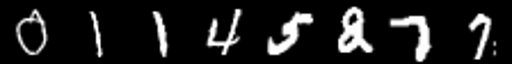

In [4]:
data_provider=T.load_mnist('mnist')   #取得mnist數據集

im,label=data_provider.next() #調用一次以獲取一個minibatch的數據與標籤
print(im.shape)
im=array2image(np.concatenate(im[:8],axis=1)).resize((64*8,64))
#取8筆，把形狀reshapet成(8,28,28)且反正規化，並且沿著寬的方向(axis=1)疊合，並且把圖片尺寸放大到(64*8,64)

data_provider.image_transform_funcs=[Normalize(127.5,127.5)]  #利用減127.5除以127.5的方式來正規化圖片向量(值域會落在正負1之間)
im


archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
(8, 28, 28, 1)


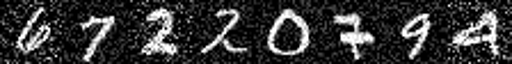

In [5]:
noise_data_provider=T.load_mnist('mnist')#取得mnist數據集
noise_data_provider.image_transform_funcs=[AddNoise(intensity=0.3)]
noise_im,noise_label=noise_data_provider.next() #調用一次以獲取一個minibatch的數據與標籤
print(noise_im.shape)
noise_im=array2image(np.concatenate(noise_im[:8],axis=1)).resize((64*8,64))
#取8筆，把形狀reshapet成(8,28,28)且反正規化，並且沿著寬的方向(axis=1)疊合，並且把圖片尺寸放大到(64*8,64)
noise_data_provider.image_transform_funcs=[AddNoise(intensity=0.3),Normalize(127.5,127.5)]#除了正規化之外`,，額外添加30%噪音    
noise_im

In [6]:
activations=['relu','leaky_relu','sigmoid','tanh','selu','swish','mish','gelu','SIREN']
#performance_dict用來儲存每個步驟的效果指標
performance_dict=OrderedDict()

接下來就把要測試的目標包裝成測試函數

In [7]:
def test_activity_function(act):
    performance_dict[act]=OrderedDict()
    #清掉記憶體垃圾以避免影響效能
    gc.collect()
    act_func=get_activation(act)
    print(act)
    
    #計算跑 10 萬次的總時間
    data =to_tensor(np.random.standard_normal((100000,1))) 
    start = time.time()
    results=[act_func(data[i]) for  i  in range(100000)]
    sec = time.time() - start
    print('{0:.6f} sec'.format(sec))
    performance_dict[act]['跑 10 萬次的總時間']=sec

    #建 mnist模
    net=Sequential(
    Flatten(),
    Dense(128,use_bias=False,activation=act),
    Dense(64,use_bias=False,activation=act),
    Dense(10,use_bias=False,activation=None),
    SoftMax())
    
    
    model=Model(input_shape=(28,28,1),output=net)\
    .with_optimizer(optimizer='SGD',lr=1e-3)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)
    
    plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(data_provider)\
    .with_batch_size(128)\
    .print_progress_scheduling(100,unit='batch')\

    #讓他跑1000 次，過程中的權重變化與梯度變化都保留
    plan.only_steps(num_steps=1000,collect_data_inteval=10,keep_weights_history=True,keep_gradient_history=True )
    
    loss_indexs,loss_values=model.training_context['losses'].get_series('total_losses')
    accuracy_indexs,accuracy_values=model.training_context['metrics'].get_series('accuracy')
    print('最低 loss {0:.4e}  最佳 metrics {1:.4%}  最後10次 metrics {2:.4%}'.format(np.array(loss_values).min(),
                                                                              np.array(accuracy_values).max(),
                                                                              np.array(accuracy_values)[-10:].mean()))
    performance_dict[act]['最佳 metrics'] =np.array(accuracy_values).max()
    performance_dict[act]['最後10次 metrics'] =np.array(accuracy_values)[-10:].mean()
    # 分別使用乾淨數據與噪聲數據進行推論
    net.eval()
    accuracys=[]
    for i in range(100):
        input,target=data_provider.next()
        input,target=to_tensor(input),to_tensor(target)
        accuracys.append(to_numpy(accuracy(net(input),target)))
    accuracys=np.asarray(accuracys)
        
    print('正常樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(accuracys.mean(),accuracys.mean()-performance_dict[act]['最後10次 metrics']))
    performance_dict[act]['正常樣本 accuracy DIFF']=accuracys.mean()-performance_dict[act]['最後10次 metrics']
    
    
    noise_accuracys=[]
    for i in range(100):
        input,target=noise_data_provider.next()
        input,target=to_tensor(input),to_tensor(target)
        noise_accuracys.append(to_numpy(accuracy(net(input),target)))
    noise_accuracys=np.asarray(noise_accuracys)
        
    print('噪聲樣本 accuracy {0:.4%}  DIFF: {1:.4%} '.format(noise_accuracys.mean(),noise_accuracys.mean()-performance_dict[act]['最後10次 metrics']))
    performance_dict[act]['噪聲樣本 accuracy DIFF']=noise_accuracys.mean()-performance_dict[act]['最後10次 metrics']
    
    
    #繪製梯度與權重分布
    weights_history=plan.training_items[0].weights_history
    gradients_history=plan.training_items[0].gradients_history
    
    grads=[]
    weights=[]
    for i in range(len(gradients_history)):
        grads.append(gradients_history[i].value_list[0].reshape([-1]))

    for i in range(len(weights_history)):
         weights.append(weights_history[i].value_list[0].reshape([-1]))
    
    grads=np.asarray(grads)
    weights=np.asarray(weights)
    #計算梯度為零比例
    print('梯度為零比例 : {0:.3%}'.format(np.equal(grads,0).astype(np.float32).mean()))
    performance_dict[act]['梯度為零比例']=np.equal(grads,0).astype(np.float32).mean()
    performance_dict[act]['負梯度比例']=np.less(grads,0).astype(np.float32).mean()
    
    steps_histogram(grads,weights,inteval=50,imshow=True)
    
    
    fig = plt.figure(figsize=(18,8))
    for i in [1,2]:
        ax= fig.add_subplot(1, 2, i, projection = '3d')


        # Make data.
        X = np.arange(0, 28, 1)
        Y = np.arange(0, 28, 1)
        X, Y = np.meshgrid(X, Y)
        
        grad_grid=gradients_history[0 if i==1 else-1].value_list[0][:,0].reshape([28,28])
        Z = grad_grid[Y,X]

        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

        # Customize the z axis.
        ax.set_zlim(grad_grid.min()*1.1,grad_grid.max()*1.1)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

        fig.colorbar(surf, shrink=0.5, aspect=5)

    display.display(plt.gcf())
    plt.close(fig)
   

relu
52.092641 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_1 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.664, total_losses: 2.664 }
sequential_1  Step: 96ms     | Loss: 2.664 | accuracy: 6.250%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_1  Step: 44s216ms | Loss: 2.461 | accuracy: 13.366%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_1  Step: 48s814ms | Loss: 2.352 | accuracy: 29.586%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_1  Step: 45s255ms | Loss: 2.273 | accuracy: 41.883%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_1  Step: 48s322ms | Loss: 2.207 | accuracy: 51.438%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_1  Step: 58s808ms | Loss: 2.149 | accuracy: 57.469%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
seque

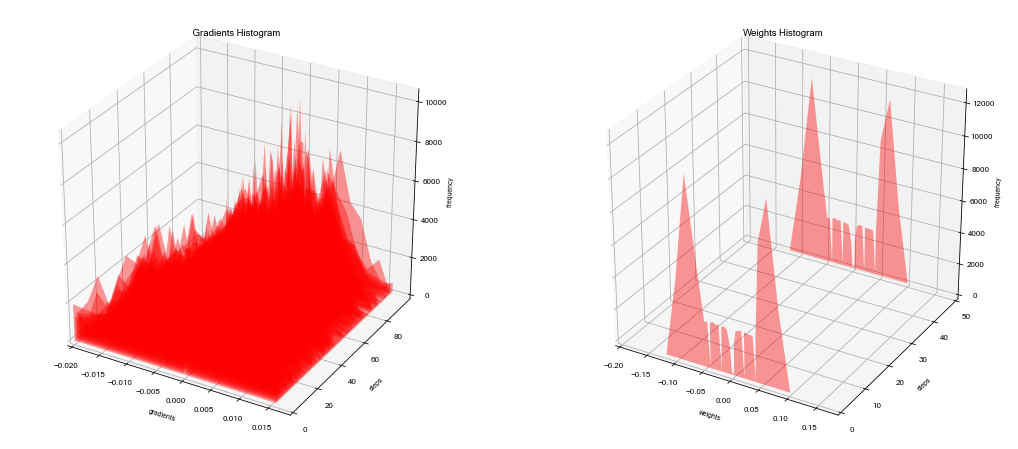

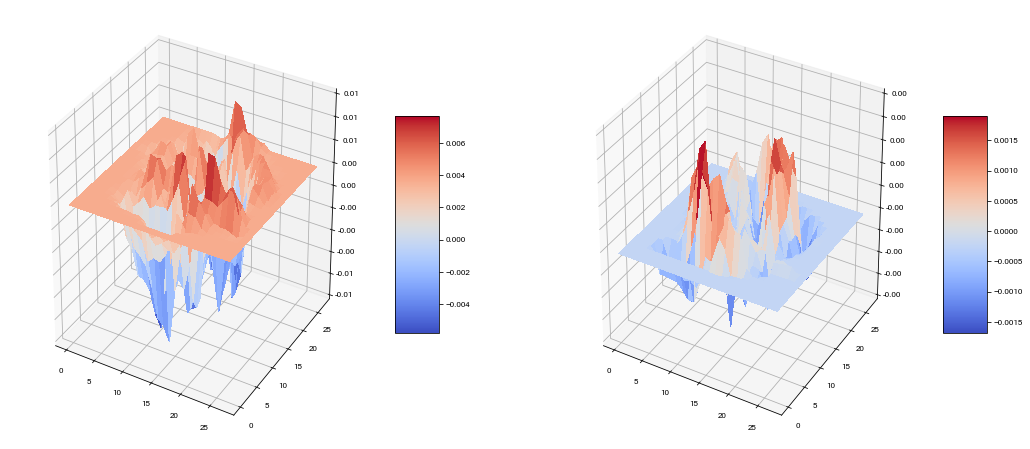

In [8]:
test_activity_function('relu')

leaky_relu
38.197300 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_2 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.507, total_losses: 2.507 }
sequential_2  Step: 63ms     | Loss: 2.507 | accuracy: 9.375%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_2  Step: 58s336ms | Loss: 2.395 | accuracy: 14.024%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_2  Step: 43s983ms | Loss: 2.325 | accuracy: 30.898%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_2  Step: 49s229ms | Loss: 2.268 | accuracy: 43.172%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_2  Step: 46s296ms | Loss: 2.217 | accuracy: 53.508%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_2  Step: 45s430ms | Loss: 2.169 | accuracy: 60.031%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )

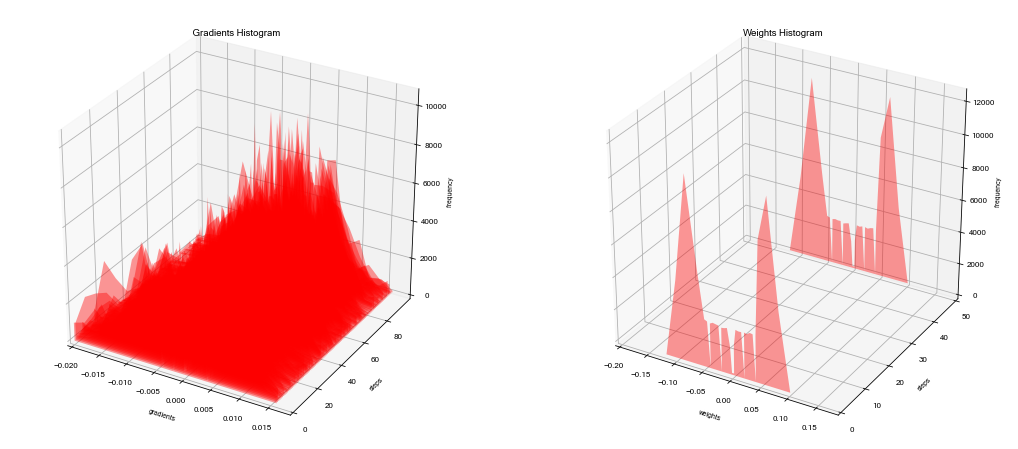

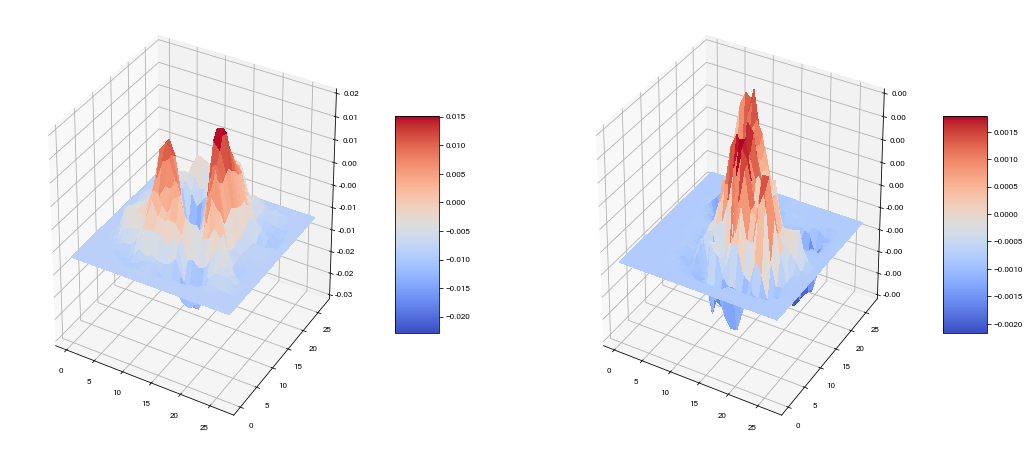

In [9]:
test_activity_function('leaky_relu')

sigmoid
36.613757 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_3 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.656, total_losses: 2.656 }
sequential_3  Step: 66ms     | Loss: 2.656 | accuracy: 10.156%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_3  Step: 40s701ms | Loss: 2.628 | accuracy: 10.110%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_3  Step: 39s565ms | Loss: 2.597 | accuracy: 9.453%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_3  Step: 39s45ms  | Loss: 2.572 | accuracy: 9.555%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_3  Step: 44s606ms | Loss: 2.550 | accuracy: 9.891%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_3  Step: 57s707ms | Loss: 2.532 | accuracy: 10.969%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
sequ

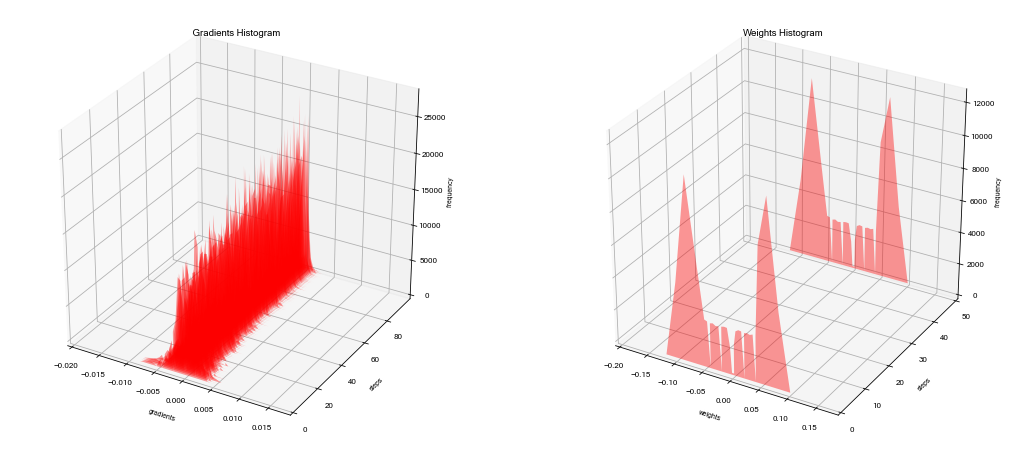

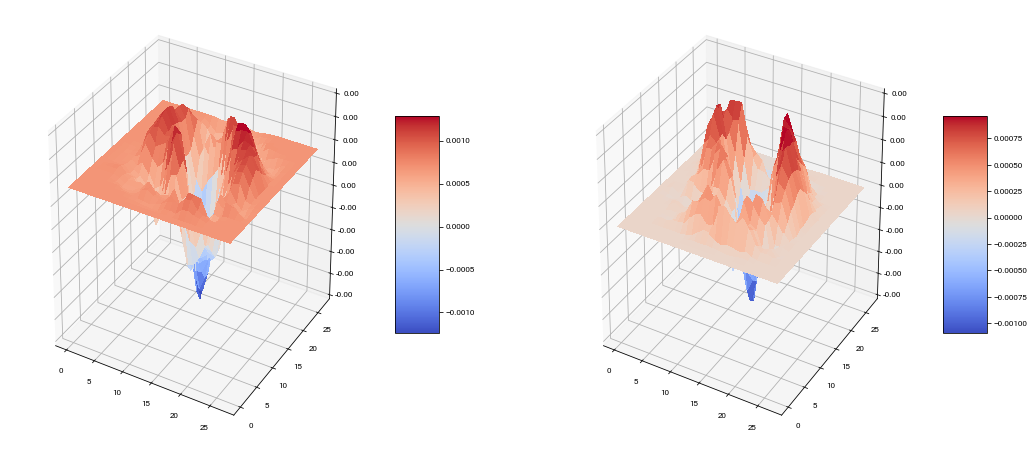

In [10]:
test_activity_function('sigmoid')

tanh
39.848797 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_4 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.488, total_losses: 2.488 }
sequential_4  Step: 120ms    | Loss: 2.488 | accuracy: 14.062%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_4  Step: 48s788ms | Loss: 2.397 | accuracy: 15.045%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_4  Step: 43s788ms | Loss: 2.317 | accuracy: 32.375%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_4  Step: 37s237ms | Loss: 2.251 | accuracy: 44.203%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_4  Step: 41s497ms | Loss: 2.193 | accuracy: 50.922%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_4  Step: 44s906ms | Loss: 2.141 | accuracy: 57.875%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
sequ

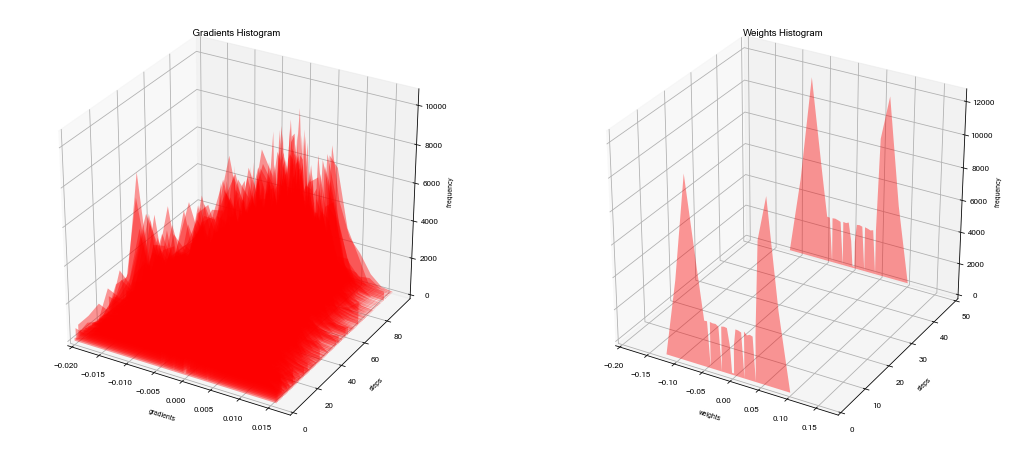

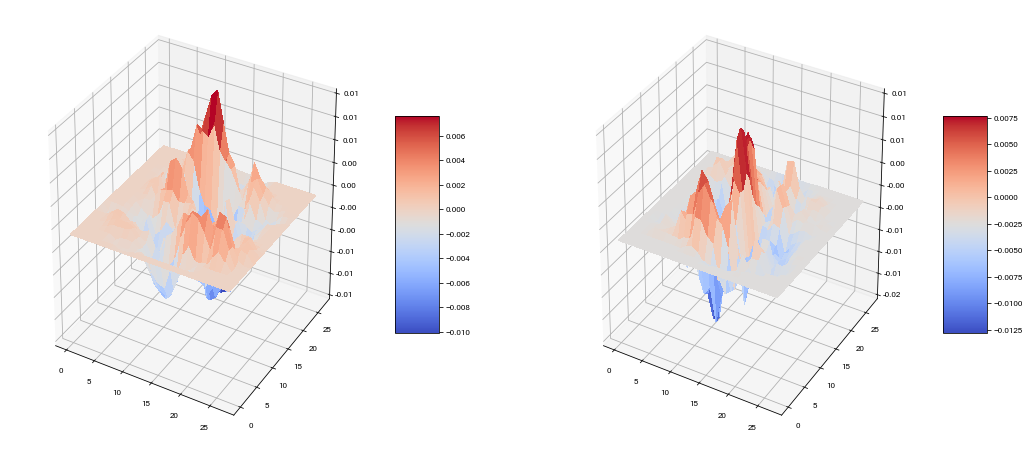

In [11]:
test_activity_function('tanh')

selu
36.689199 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_5 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 4.065, total_losses: 4.065 }
sequential_5  Step: 85ms     | Loss: 4.065 | accuracy: 7.031%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_5  Step: 35s736ms | Loss: 2.740 | accuracy: 21.790%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_5  Step: 36s4ms   | Loss: 2.450 | accuracy: 46.164%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_5  Step: 37s800ms | Loss: 2.262 | accuracy: 60.555%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_5  Step: 41s214ms | Loss: 2.121 | accuracy: 67.484%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_5  Step: 42s904ms | Loss: 2.008 | accuracy: 73.016%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
seque

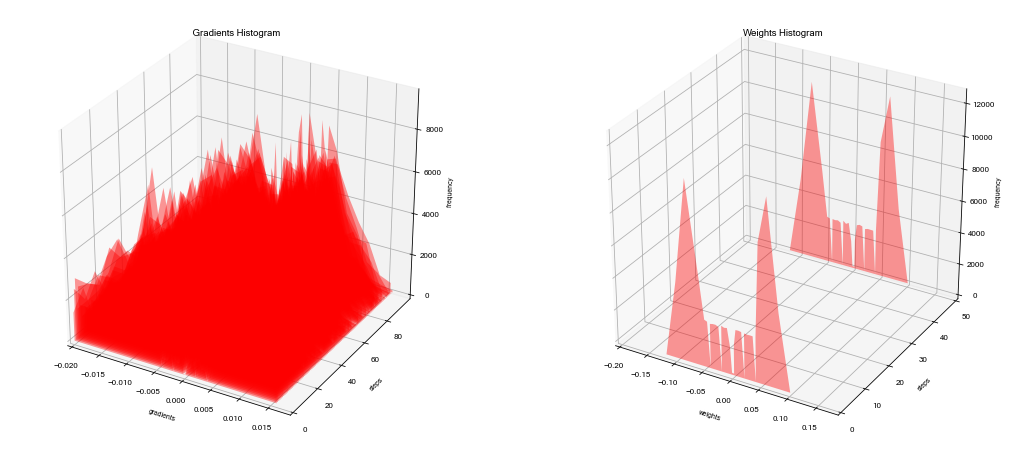

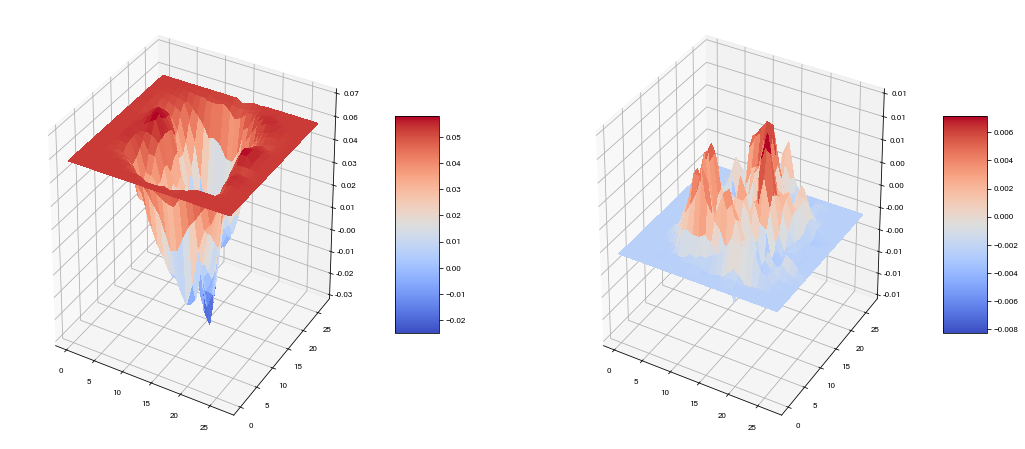

In [12]:
test_activity_function('selu')

swish
23.762582 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_6 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.381, total_losses: 2.381 }
sequential_6  Step: 43ms     | Loss: 2.381 | accuracy: 10.938%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_6  Step: 22s324ms | Loss: 2.375 | accuracy: 13.165%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_6  Step: 22s261ms | Loss: 2.328 | accuracy: 23.633%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_6  Step: 24s683ms | Loss: 2.290 | accuracy: 36.133%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_6  Step: 27s      | Loss: 2.254 | accuracy: 44.906%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_6  Step: 34s560ms | Loss: 2.220 | accuracy: 51.219%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
seq

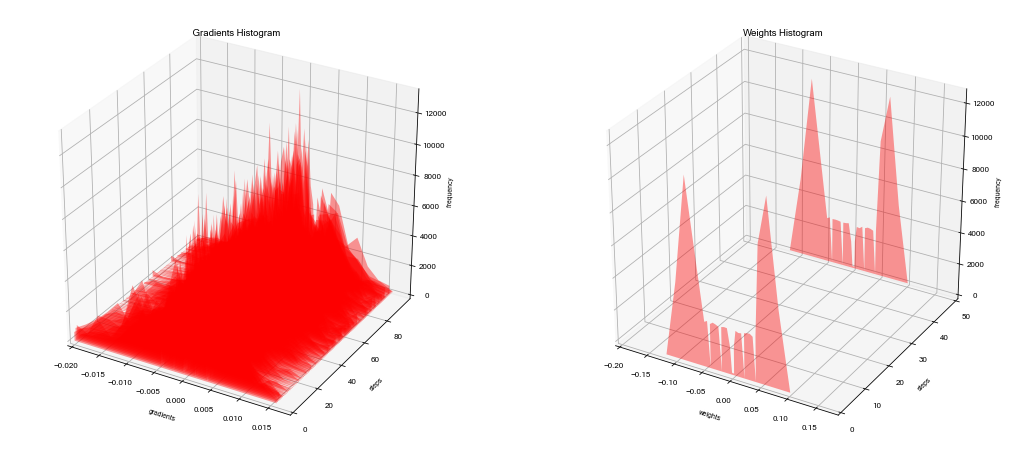

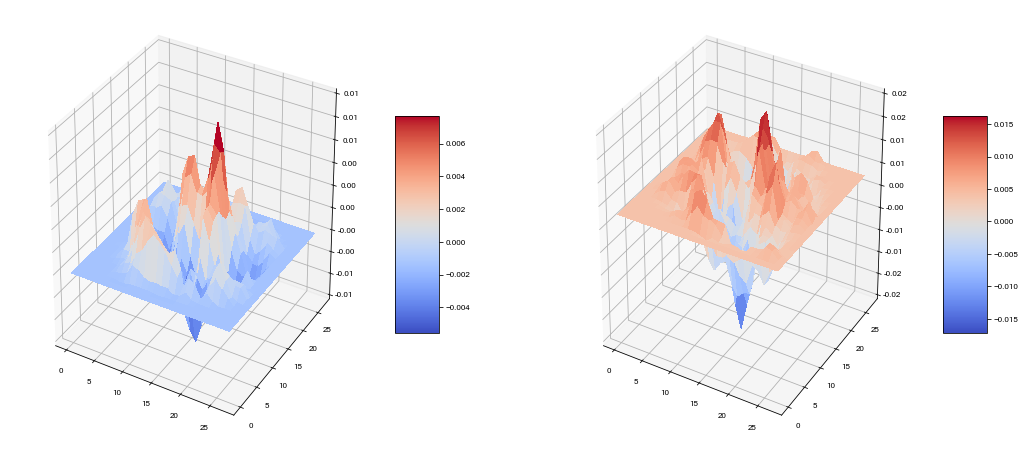

In [13]:
test_activity_function('swish')

mish
24.094714 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_7 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.564, total_losses: 2.564 }
sequential_7  Step: 36ms     | Loss: 2.564 | accuracy: 3.125%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_7  Step: 28s88ms  | Loss: 2.437 | accuracy: 14.929%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_7  Step: 27s125ms | Loss: 2.360 | accuracy: 30.039%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_7  Step: 24s454ms | Loss: 2.295 | accuracy: 42.406%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_7  Step: 23s351ms | Loss: 2.237 | accuracy: 52.000%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_7  Step: 24s603ms | Loss: 2.183 | accuracy: 58.086%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
seque

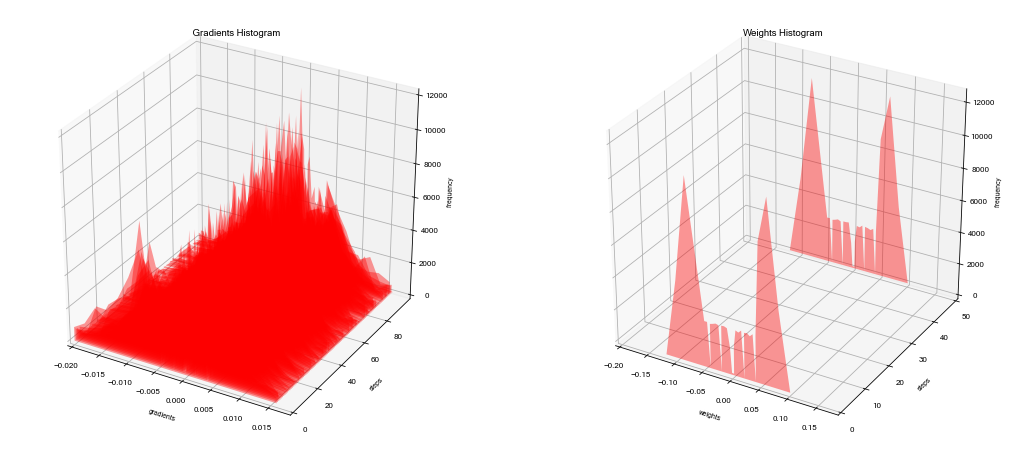

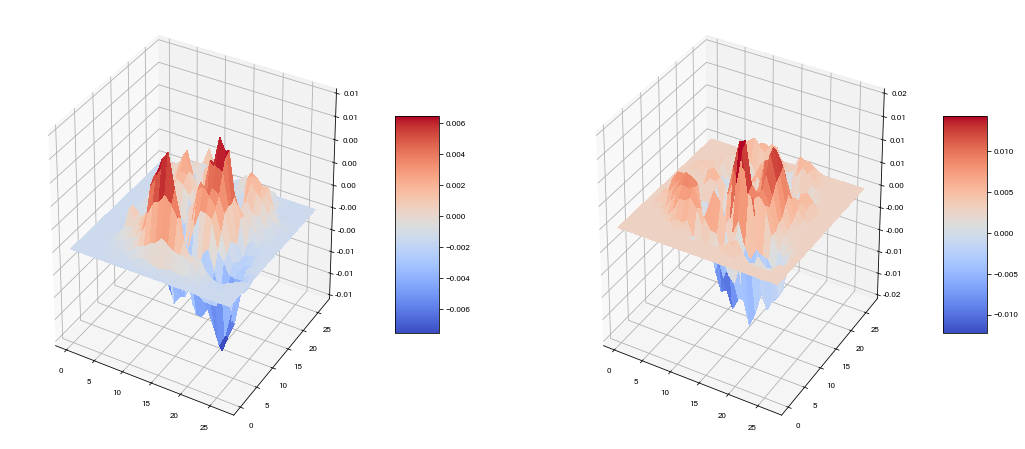

In [14]:
test_activity_function('mish')

gelu
42.682059 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_8 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.484, total_losses: 2.484 }
sequential_8  Step: 39ms     | Loss: 2.484 | accuracy: 8.594%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_8  Step: 23s89ms  | Loss: 2.372 | accuracy: 12.972%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_8  Step: 21s627ms | Loss: 2.317 | accuracy: 26.742%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_8  Step: 20s950ms | Loss: 2.270 | accuracy: 37.898%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_8  Step: 25s170ms | Loss: 2.227 | accuracy: 47.578%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_8  Step: 23s129ms | Loss: 2.186 | accuracy: 53.656%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000 )
seque

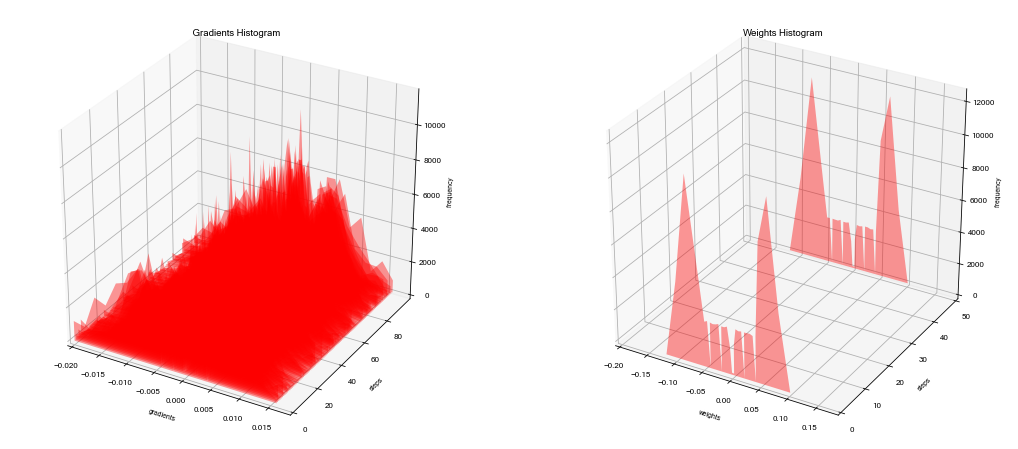

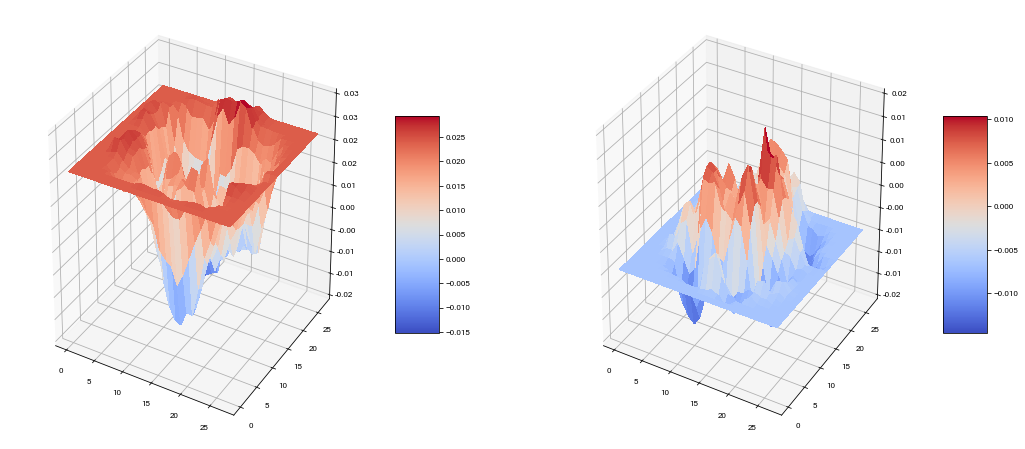

In [15]:
test_activity_function('gelu')

SIREN
124.299778 sec
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
data_feed for sequential_10 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ CrossEntropyLoss: 2.644, total_losses: 2.644 }
sequential_10  Step: 128ms    | Loss: 2.644 | accuracy: 9.375%  | learning rate: 1.000e-03  | epoch: 0  ( 0/1000 )
sequential_10  Step: 1m4s     | Loss: 2.754 | accuracy: 9.847%  | learning rate: 1.000e-03  | epoch: 0  ( 100/1000 )
sequential_10  Step: 47s548ms | Loss: 2.758 | accuracy: 10.047%  | learning rate: 1.000e-03  | epoch: 0  ( 200/1000 )
sequential_10  Step: 46s367ms | Loss: 2.757 | accuracy: 10.359%  | learning rate: 1.000e-03  | epoch: 0  ( 300/1000 )
sequential_10  Step: 54s195ms | Loss: 2.756 | accuracy: 10.148%  | learning rate: 1.000e-03  | epoch: 0  ( 400/1000 )
sequential_10  Step: 43s754ms | Loss: 2.754 | accuracy: 10.641%  | learning rate: 1.000e-03  | epoch: 0  ( 500/1000

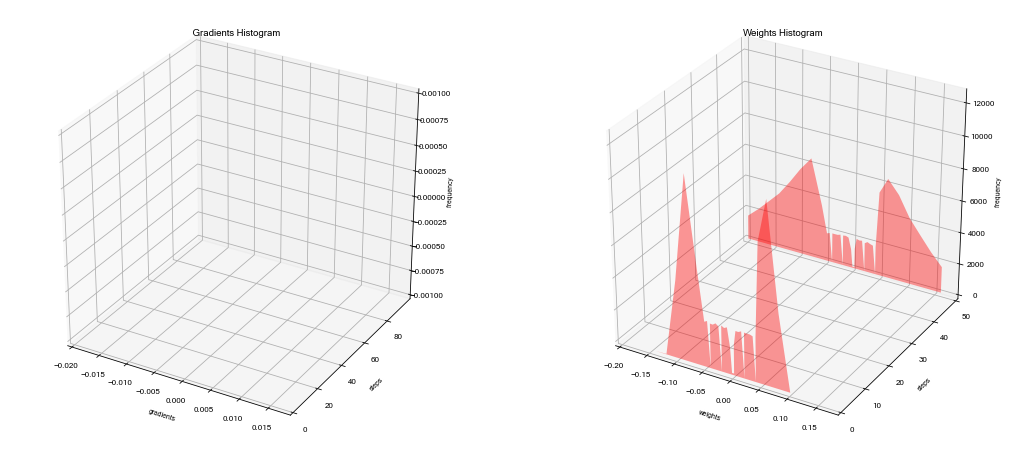

IndexError: invalid index to scalar variable.

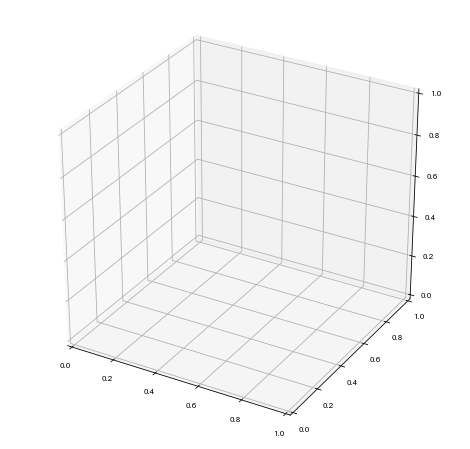

In [17]:
test_activity_function('SIREN')

首先要來看的是這幾個活化函數的計算開銷，我們紀錄每個活化函數各執行1萬次的執行時間長度，我們可以發現gelu的計算開銷是遠大於其他活化函數的。接下來我們想要看看這些模型實際面對測試數據以及面臨到數據品質極差的樣本時，是不是具有足夠的泛化能力。這邊可以看到新生代的活化函數整體上看來，泛化能力是排後段班的。  

接下來我們將收集的梯度與權重歷程(我們是設定collect_data_inteval=100，即每100批次收集一次數據)，首先是看梯度分布的狀況，由於這個直方圖的z軸高度是根據圖表的最大值設定的，因此如果你看到有些圖看起來梯度很稀疏，幾乎看不到紅色區域，那就是它的梯度都集中在特定點(通常是0)，你可以看到relu是全部中梯度為零比例最高者，leaky_relu看起來很有效的緩解了relu梯度為零的缺陷，新生代的活化函數的梯度為零比率看起來表現尚可。

整體來看，新舊各有優點，老實說活化函數的影響其實低於優化器或者是權重初始化，若要我給個結論，我會建議的是：「別再使用relu了，如果你習慣傳統活化函數的低計算開銷，建議改成leaky_relu，如果你想嘗試新的活化函數，selu看起來是比較好的選擇」

In [18]:
import pandas
#將performance_dict轉成表格
pd=pandas.DataFrame.from_dict(performance_dict)
pd

,relu,leaky_relu,sigmoid,tanh,selu,swish,mish,gelu,SIREN
跑 10 萬次的總時間,52.092641,38.197300,36.613757,39.848797,36.689199,23.762582,24.094714,42.682059,124.299778
最佳 metrics,0.737187,0.761068,0.169531,0.732254,0.824219,0.705469,0.745399,0.732552,0.131250
最後10次 metrics,0.730551,0.756143,0.144688,0.727585,0.817623,0.696152,0.738718,0.721005,0.105406
正常樣本 accuracy DIFF,0.013668,0.011045,-0.012813,0.013352,0.002924,0.013301,0.020423,0.021182,-0.003843
噪聲樣本 accuracy DIFF,-0.053051,-0.026142,-0.019688,-0.056335,-0.062623,-0.008652,-0.033718,-0.041005,-0.024156
梯度為零比例,0.050313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
負梯度比例,0.463840,0.471260,0.485366,0.495567,0.493954,0.473721,0.491088,0.458437,0.610000
